<a href="https://colab.research.google.com/github/dhnanjay/HuggingFace/blob/main/FLAN_T5_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keys

In [ ]:
import os
os.environ["WANDB_API_KEY"] = ""

# Our First Reinforcement Learning from Feedback Loop

In [2]:
!pip install wandb datasets transformers tqdm trl -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are insta

### Import dependencies

In [3]:
import random
import wandb
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt

tqdm.pandas()

from datasets import load_dataset

from transformers import AutoTokenizer, pipeline

from trl import PPOTrainer, PPOConfig, create_reference_model, AutoModelForSeq2SeqLMWithValueHead
import os
import torch

import os


wandb.login(key=os.environ['WANDB_API_KEY'])

device = "cuda" if torch.cuda.is_available() else "cpu"

device

wandb: Currently logged in as: dkumar217. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


'cuda'

# The Reward Pipeline

In [4]:
sentiment_pipeline = pipeline('text-classification', 'cardiffnlp/twitter-roberta-base-sentiment')

def get_neutral_scores(texts):
    scores = []
    # function_to_apply='none' returns logits which can be negative which is great for RL rewards
    results = sentiment_pipeline(texts, function_to_apply='none', top_k=None)
    for result in results:
        for label in result:
            if label['label'] == 'LABEL_1':  # logit for neutral class
                scores.append(label['score'])
    return scores

get_neutral_scores(['hello', 'I love you!', 'I hate you'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

[0.851918637752533, -0.7468027472496033, -0.5696872472763062]

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("textattack/roberta-base-CoLA")
model = AutoModelForSequenceClassification.from_pretrained("textattack/roberta-base-CoLA")

cola_pipeline = pipeline('text-classification', model=model, tokenizer=tokenizer)

def get_cola_scores(texts):
    scores = []
    # note function_to_apply='none' gives me logits which can be negative (what we want)
    results = cola_pipeline(texts, function_to_apply='none', top_k=None)
    for result in results:
        for label in result:
            if label['label'] == 'LABEL_1':  # good grammar:
                scores.append(label['score'])
    return scores


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
test = """German police arrest 29-year-old man suspected of plotting truck attack on ice rink in Berlin,
killing 12 people, Reuters-German police say: 'It's a shame to have been arrested,'
a German police spokesman said in a statement."""

print(get_cola_scores([test]))
print(get_neutral_scores([test]))

[-0.380087286233902]
[0.3111611008644104]


In [7]:
MODEL_NAME = "google/flan-t5-small"

# RL Configuration

In [8]:
config = PPOConfig(
    model_name=MODEL_NAME,
    batch_size=8,
    learning_rate=2e-5,
    remove_unused_columns=False,
    log_with="wandb",
    gradient_accumulation_steps=4,
)

np.random.seed(42)

In [9]:
flan_t5_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(
    config.model_name
)  # going to be updated. and this our agent

flan_t5_model_ref = create_reference_model(flan_t5_model)  # is never updated -> this is our reference model, not to be updated
flan_t5_tokenizer = AutoTokenizer.from_pretrained(config.model_name)


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [10]:
from datasets import load_dataset

dataset = load_dataset("argilla/news-summary")

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20417 [00:00<?, ? examples/s]

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 20417
    })
})

In [12]:
dataset['train'][0]

{'text': 'PHNOM PENH (Reuters) - Sweden said on Tuesday it was stopping new aid for Cambodia, except in education and research, and would no longer support a reform programme after the main opposition party was outlawed by the Supreme Court at the government s request. The announcement marked the first concrete action by a European Union country in protest at a political crackdown in which veteran Prime Minister Hun Sen s main rival has also been arrested and civil rights groups and independent media attacked. The United States cut election funding and said it would take more punitive steps after last week s ban on the Cambodia National Rescue Party (CNRP). The European Union has also threatened action. Sweden s embassy in Phnom Penh said the country was reviewing its engagement with Cambodia.   We will not initiate any new government-to-government development cooperation agreements, except in the areas of education and research,  it said in a statement. As a consequence, it would be u

In [13]:

# Preprocessing function
def preprocess(batch):
    # 'texts' should be a list of text entries within each batch
    texts = batch['text']  # assuming the key for your texts in your dataset is 'text'

    # Tokenize the texts (appending 'summarize: ' before each)
    tokenized_inputs = flan_t5_tokenizer(
        ['summarize: ' + t for t in texts],
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

      # Remove padding
    input_ids_list = []
    attention_mask_list = []

    for idx, input_ids in enumerate(tokenized_inputs['input_ids']):
        actual_length = tokenized_inputs['attention_mask'][idx].sum()  # Count number of non-padding tokens
        input_ids_list.append(input_ids[:actual_length])
        attention_mask_list.append(tokenized_inputs['attention_mask'][idx, :actual_length])

    batch['input_ids'] = input_ids_list
    batch['attention_mask'] = attention_mask_list

    return batch

dataset['train'] = dataset['train'].map(
    preprocess,
    batched=True,
    batch_size=256,
    remove_columns=set(dataset['train'].column_names) - {'text',}
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
dataset.set_format("pytorch")

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 20417
    })
})

In [15]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

# Load our reference FLAN-T5 Model

In [16]:
generation_kwargs = {
    "min_length": 64,  # forcing some behavior I want
    "num_beams": 5,  # lookahead parameter
    "no_repeat_ngram_size": 3,  # cannot say the same three n-grams in a row twice
    "do_sample": True,  # giving the LLM freedom to experiment
    "pad_token_id": flan_t5_tokenizer.pad_token_id,  # technically not needed in this example, but is if doing PPO in larger batches
    "max_length": 256,
    "eos_token_id": flan_t5_tokenizer.eos_token_id,
}


In [17]:
%%time
ppo_trainer = PPOTrainer(
    config, flan_t5_model,
    flan_t5_model_ref, flan_t5_tokenizer, dataset['train'],
    data_collator=collator
)

CPU times: user 420 ms, sys: 237 ms, total: 657 ms
Wall time: 2.37 s


### Our RLF Loop


In [ ]:
%%time
from tqdm.auto import tqdm
for epoch in tqdm(range(2)):
    for batch in tqdm(ppo_trainer.dataloader):
        game_data = dict()
        #### prepend the summarize token
        game_data["query"] = ['summarize: ' + b for b in batch["text"]]

        #### get response from flan-t5
        input_tensors = [_.squeeze() for _ in batch["input_ids"]]
        response_tensors = []
        for query in input_tensors:
            response = ppo_trainer.generate(query.squeeze(), **generation_kwargs)
            response_tensors.append(response.squeeze())

        game_data["response"] = [flan_t5_tokenizer.decode(r.squeeze(), skip_special_tokens=False) for r in response_tensors]

        #### reward system
        game_data["clean_response"] = [flan_t5_tokenizer.decode(r.squeeze(), skip_special_tokens=True) for r in response_tensors]
        game_data['cola_scores'] = get_cola_scores(game_data["clean_response"])
        game_data['neutral_scores'] = get_neutral_scores(game_data["clean_response"])
        # rewards = game_data['neutral_scores']
        transposed_lists = zip(game_data['cola_scores'], game_data['neutral_scores'])
        # Calculate the averages for each index
        rewards = [1 * values[0] +  0.5 * values[1] for values in transposed_lists]
        rewards = [torch.tensor([_]) for _ in rewards]
        # print(rewards)  # just to inspect :)

        #### Run PPO training
        stats = ppo_trainer.step(input_tensors, response_tensors, rewards)

        stats['env/reward'] = np.mean([r.cpu().numpy() for r in rewards])
        ppo_trainer.log_stats(stats, game_data, rewards)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.73 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1212: UserWarning: The average ratio of batch (68.93) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


In [ ]:
# save locally
flan_t5_model.save_pretrained("t5-align")
flan_t5_tokenizer.save_pretrained("t5-align")

('t5-align/tokenizer_config.json',
 't5-align/special_tokens_map.json',
 't5-align/tokenizer.json')

In [ ]:
username, repo_name = 'profoz', 't5-aligned-summaries'

# Push model and tokenizer to Hugging Face Hub
flan_t5_model.push_to_hub(f"{username}/{repo_name}")
flan_t5_tokenizer.push_to_hub(f"{username}/{repo_name}")

Some weights of the model checkpoint at t5-align were not used when initializing T5ForConditionalGeneration: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/profoz/t5-aligned-summaries/commit/87f8a5d71333a65af0e21e59d4076a684cc243ee', commit_message='Upload tokenizer', commit_description='', oid='87f8a5d71333a65af0e21e59d4076a684cc243ee', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
old_summarizer = pipeline("text2text-generation", MODEL_NAME, device=0)
new_summarizer = pipeline("text2text-generation", 'profoz/t5-aligned-summaries', device=0)

In [ ]:
import random

# Assuming load_dataset function loads the dataset
dataset = load_dataset("argilla/news-summary")['test']['text']

# Filter dataset for entries with less than 400 characters
filtered_dataset = [text for text in dataset if len(text) < 450 and len(text) > 200]

filtered_dataset = random.sample(filtered_dataset, len(filtered_dataset))

In [ ]:
import matplotlib.pyplot as plt

old_summaries, new_summaries = [], []
# Lists to store scores
summary_list, sentiment_scores_old, sentiment_scores_new, cola_scores_old, cola_scores_new = [], [], [], [], []

for i, article in enumerate(tqdm(filtered_dataset)):
    # Old model
    results_old = old_summarizer(f"summarize: {article}", **generation_kwargs)
    summary_text_old = results_old[0]['generated_text']
    old_summaries.append(summary_text_old)

    # New model
    results_new = new_summarizer(f"summarize: {article}", **generation_kwargs)
    summary_text_new = results_new[0]['generated_text']
    new_summaries.append(summary_text_new)

    # if summary_text_new.endswith('.') and '...' not in summary_text_new:
    # print(f"Generated Summary {i+1} [NEW]: {summary_text_new}")

    # Old scores
    sentiment_score_old = get_neutral_scores([summary_text_old])
    sentiment_scores_old.extend(sentiment_score_old)
    cola_score_old = get_cola_scores([summary_text_old])
    cola_scores_old.extend(cola_score_old)

    # New scores
    sentiment_score_new = get_neutral_scores([summary_text_new])
    sentiment_scores_new.extend(sentiment_score_new)
    # print(f"Neutral Rewards for Summary {i+1} [NEW]: {sentiment_score_new}")

    cola_score_new = get_cola_scores([summary_text_new])
    cola_scores_new.extend(cola_score_new)
    # print(f"Cola Rewards for Summary {i+1} [NEW]: {cola_score_new}")

Average Neutral Reward [OLD]: 1.3064811193536916
Average Cola Reward [OLD]: 0.6901628242448794
Average Neutral Reward [NEW]: 1.3233293617095314
Average Cola Reward [NEW]: 0.7584201722146664


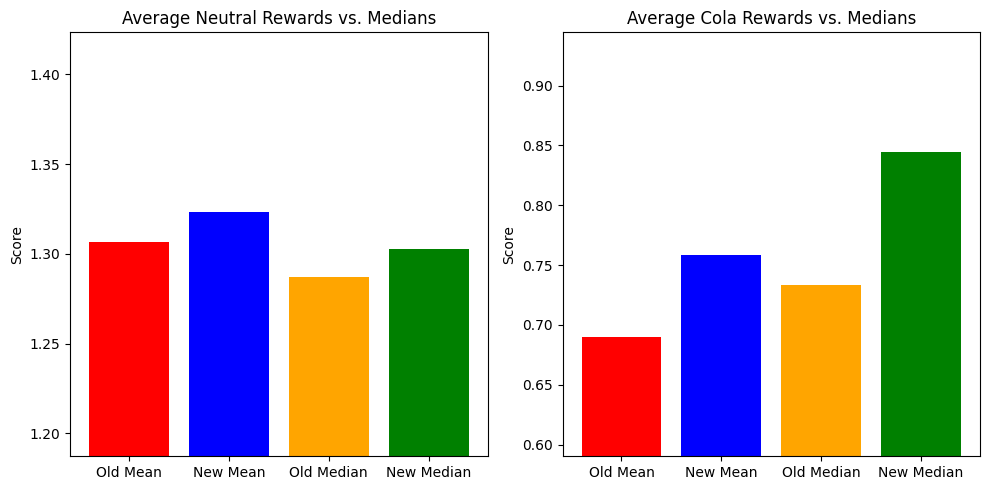

In [ ]:

# Calculate averages
average_sentiment_score_old = sum(sentiment_scores_old) / len(sentiment_scores_old)
average_cola_score_old = sum(cola_scores_old) / len(cola_scores_old)
average_sentiment_score_new = sum(sentiment_scores_new) / len(sentiment_scores_new)
average_cola_score_new = sum(cola_scores_new) / len(cola_scores_new)

median_sentiment_score_old = np.median(sentiment_scores_old)
median_cola_score_old = np.median(cola_scores_old)
median_sentiment_score_new = np.median(sentiment_scores_new)
median_cola_score_new = np.median(cola_scores_new)

std_sentiment_score_old = np.std(sentiment_scores_old)
std_cola_score_old = np.std(cola_scores_old)
std_sentiment_score_new = np.std(sentiment_scores_new)
std_cola_score_new = np.std(cola_scores_new)

print(f'Average Neutral Reward [OLD]: {average_sentiment_score_old}')
print(f'Average Cola Reward [OLD]: {average_cola_score_old}')
print(f'Average Neutral Reward [NEW]: {average_sentiment_score_new}')
print(f'Average Cola Reward [NEW]: {average_cola_score_new}')
# print('---------------------------')

# Graph the differences
plt.figure(figsize=(10, 5))

# Sentiment scores
plt.subplot(1, 2, 1)
plt.bar(["Old Mean", "New Mean", "Old Median", "New Median"],
        [average_sentiment_score_old, average_sentiment_score_new, median_sentiment_score_old, median_sentiment_score_new],
        color=['red', 'blue', 'orange', 'green'])
plt.title("Average Neutral Rewards vs. Medians")
plt.ylabel("Score")
plt.ylim(min(average_sentiment_score_old, average_sentiment_score_new, median_sentiment_score_old, median_sentiment_score_new) - 0.1,
         max(average_sentiment_score_old, average_sentiment_score_new, median_sentiment_score_old, median_sentiment_score_new) + 0.1)

# Cola scores
plt.subplot(1, 2, 2)
plt.bar(["Old Mean", "New Mean", "Old Median", "New Median"],
        [average_cola_score_old, average_cola_score_new, median_cola_score_old, median_cola_score_new],
        color=['red', 'blue', 'orange', 'green'])
plt.title("Average Cola Rewards vs. Medians")
plt.ylabel("Score")
plt.ylim(min(average_cola_score_old, average_cola_score_new, median_cola_score_old, median_cola_score_new) - 0.1,
         max(average_cola_score_old, average_cola_score_new, median_cola_score_old, median_cola_score_new) + 0.1)

plt.tight_layout()
plt.show()